In [49]:
import osmnx as ox
import matplotlib.pyplot as plt
import geopandas as gpd
import glob
import gpxpy
from shapely.geometry import LineString
import xml.etree.ElementTree as ET
import pandas as pd
import math
from datetime import datetime

In [2]:
place_name = "Oxford, England"
G = ox.graph_from_place(place_name, network_type="all")  

In [3]:
G

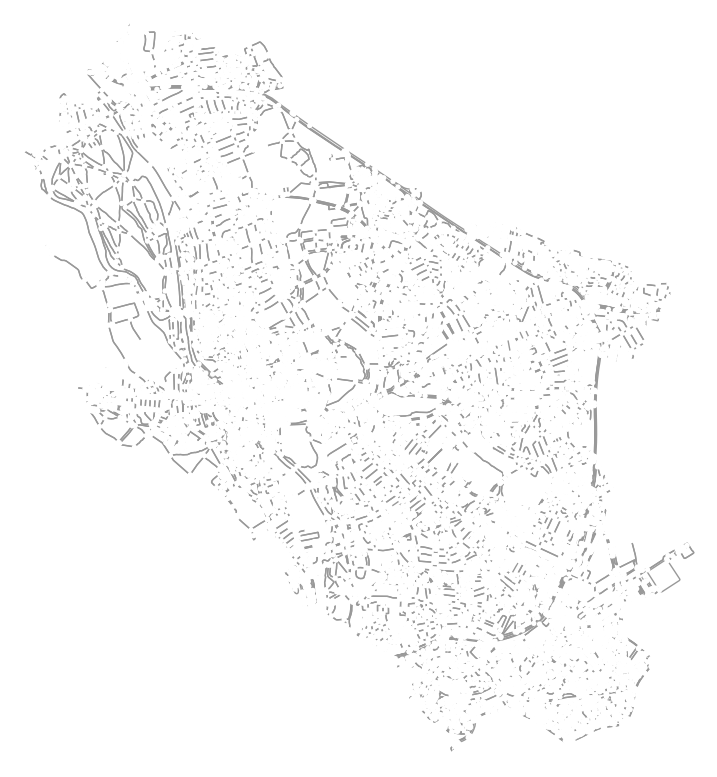

In [4]:
fig, ax = plt.subplots(figsize=(8, 8))
ox.plot_graph(G, ax=ax, show=False)
plt.tight_layout()
plt.show()

In [5]:
degrees = [d for _, d in G.degree()]

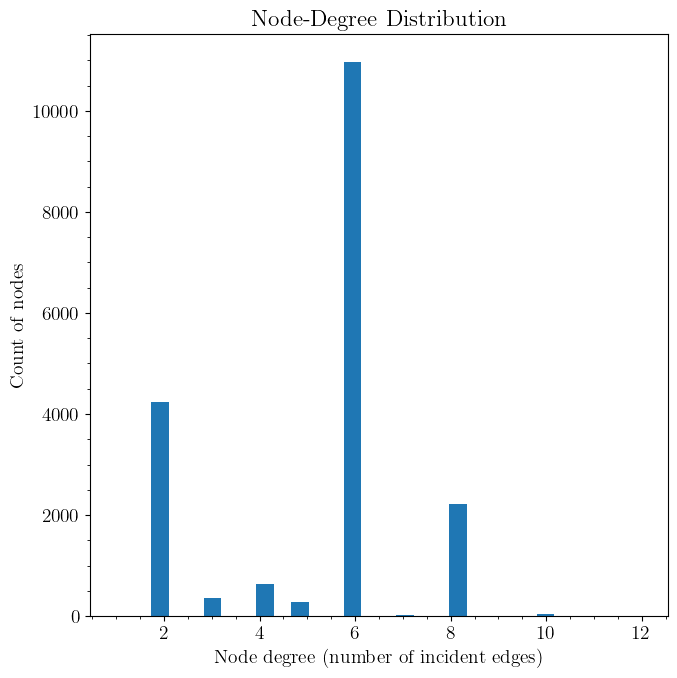

In [6]:
fig, ax = plt.subplots()
ax.hist(degrees, bins=30)
ax.set_xlabel("Node degree (number of incident edges)")
ax.set_ylabel("Count of nodes")
ax.set_title("Node‑Degree Distribution")
plt.tight_layout()
plt.show()

In [7]:
import folium


In [8]:
print(ox.__version__) 

2.0.2


In [12]:
# 1. Convert graph to GeoDataFrames
gdf_nodes, gdf_edges = ox.convert.graph_to_gdfs(G, nodes=True, edges=True)


In [13]:
gdf_edges

osmid           highway lanes  \
u           v           key                                                     
213302      10069541058 0                   130896382             trunk     3   
            4824903387  0                   490315168       residential   NaN   
            8399292861  0                   904416100           service   NaN   
213309      8399368007  0                   148359466             trunk     2   
            8399292860  0                   904416096       residential   NaN   
...                                               ...               ...   ...   
12771944836 12771944833 0    [1379290914, 1379290915]  [steps, footway]   NaN   
12771944841 12771944847 0                  1379290919           footway   NaN   
12771944847 1088414886  0                    93727920           footway   NaN   
            1088414701  0    [1379290918, 1379290919]           footway   NaN   
            12771944841 0                  1379290919           footway   NaN   

                            maxspeed  oneway  ref       reversed     length  \
u           v           key                                                   
213302      10069541058 0     50 mph    True  A40          False  37.772497   
            4824903387  0     50 mph    True  NaN          False  40.669583   
            8399292861  0     50 mph    True  NaN          False  39.934229   
213309      8399368007  0     50 mph    True  A40          False  40.878743   
            8399292860  0     50 mph    True  NaN          False  42.829431   
...                              ...     ...  ...            ...        ...   
12771944836 12771944833 0        NaN   False  NaN           True  10.448352   
12771944841 12771944847 0        NaN   False  NaN          False  47.964474   
12771944847 1088414886  0        NaN   False  NaN           True   0.503845   
            1088414701  0        NaN   False  NaN  [False, True]  13.633111   
            12771944841 0        NaN   False  NaN           True  47.964474   

                                                                      geometry  \
u           v           key                                                      
213302      10069541058 0    LINESTRING (-1.18252 51.76277, -1.18205 51.762...   
            4824903387  0    LINESTRING (-1.18252 51.76277, -1.18234 51.762...   
            8399292861  0    LINESTRING (-1.18252 51.76277, -1.18235 51.762...   
213309      8399368007  0    LINESTRING (-1.18123 51.76278, -1.18171 51.762...   
            8399292860  0    LINESTRING (-1.18123 51.76278, -1.18148 51.762...   
...                                                                        ...   
12771944836 12771944833 0    LINESTRING (-1.28422 51.79321, -1.28417 51.793...   
12771944841 12771944847 0    LINESTRING (-1.28258 51.79352, -1.28266 51.793...   
12771944847 1088414886  0    LINESTRING (-1.28308 51.79323, -1.28307 51.79323)   
            1088414701  0    LINESTRING (-1.28308 51.79323, -1.28313 51.793...   
            12771944841 0    LINESTRING (-1.28308 51.79323, -1.28295 51.793...   

                                        name junction est_width width access  \
u           v           key                                                    
213302      10069541058 0                NaN      NaN       NaN   NaN    NaN   
            4824903387  0    Merewood Avenue      NaN       NaN   NaN    NaN   
            8399292861  0                NaN      NaN       NaN   NaN    NaN   
213309      8399368007  0        London Road      NaN       NaN   NaN    NaN   
            8399292860  0    Merewood Avenue      NaN       NaN   NaN    NaN   
...                                      ...      ...       ...   ...    ...   
12771944836 12771944833 0                NaN      NaN       NaN   NaN    NaN   
12771944841 12771944847 0                NaN      NaN       NaN   NaN    NaN   
12771944847 1088414886  0                NaN      NaN       NaN   NaN    NaN   
            1088414

In [6]:
m = gdf_edges.explore(
    column="highway",
    tooltip=["highway", "length"],
    style_kwds={"weight": 2, "opacity": 0.7},
    tiles="cartodbpositron",
    zoom_start=11,
    fit_bounds=True
)


In [ ]:
m

In [14]:
gdf_edges.columns

Index(['osmid', 'highway', 'lanes', 'maxspeed', 'oneway', 'ref', 'reversed',
       'length', 'geometry', 'name', 'junction', 'est_width', 'width',
       'access', 'service', 'tunnel', 'bridge'],
      dtype='object')

In [22]:
gdf_edges = gdf_edges.to_crs(epsg=4326)

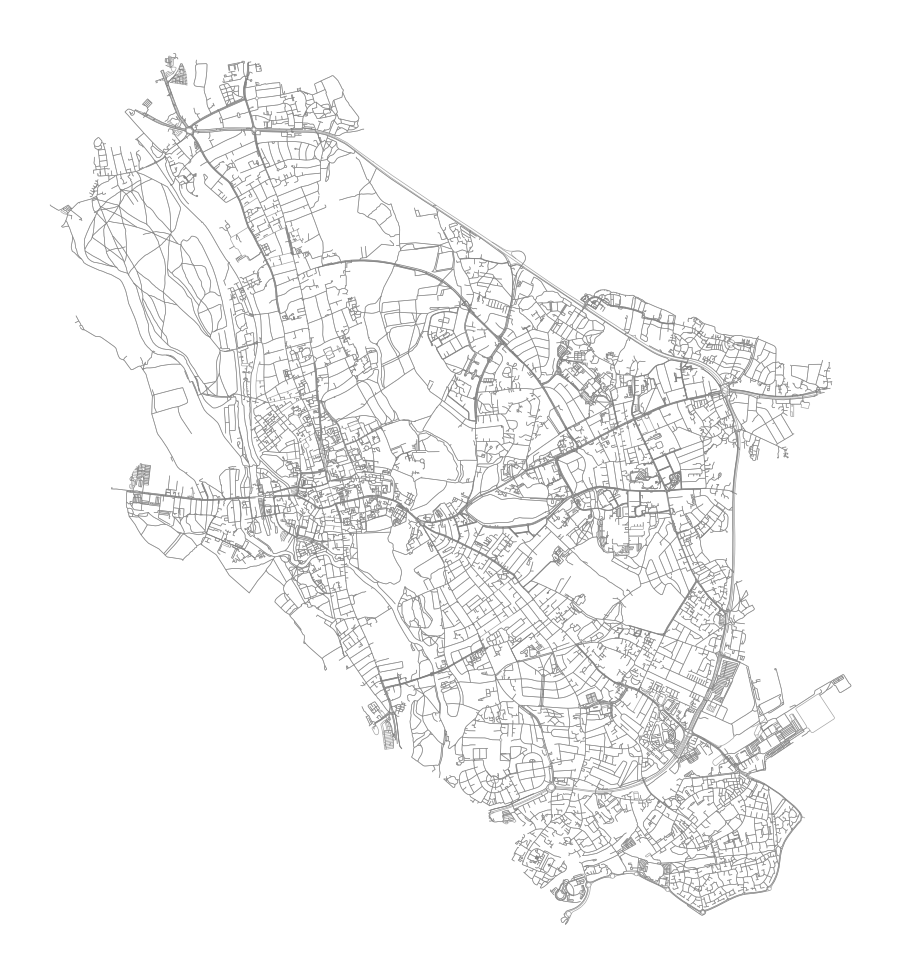

In [27]:
fig, ax = plt.subplots(figsize=(10, 10))
gdf_edges.plot(
    ax=ax,
    linewidth=0.5,       
    edgecolor="gray",    
    alpha=0.7        
)
ax.set_axis_off()
plt.tight_layout()

In [29]:
from pyrosm import OSM

In [30]:
osm = OSM("oxfordshire-latest.osm.pbf")

In [31]:
nodes, edges = osm.get_network(nodes=True, network_type="all")

In [33]:
G_route = osm.to_graph(
    nodes,
    edges,
    graph_type="networkx",
    retain_all=True  # keep disconnected components
)

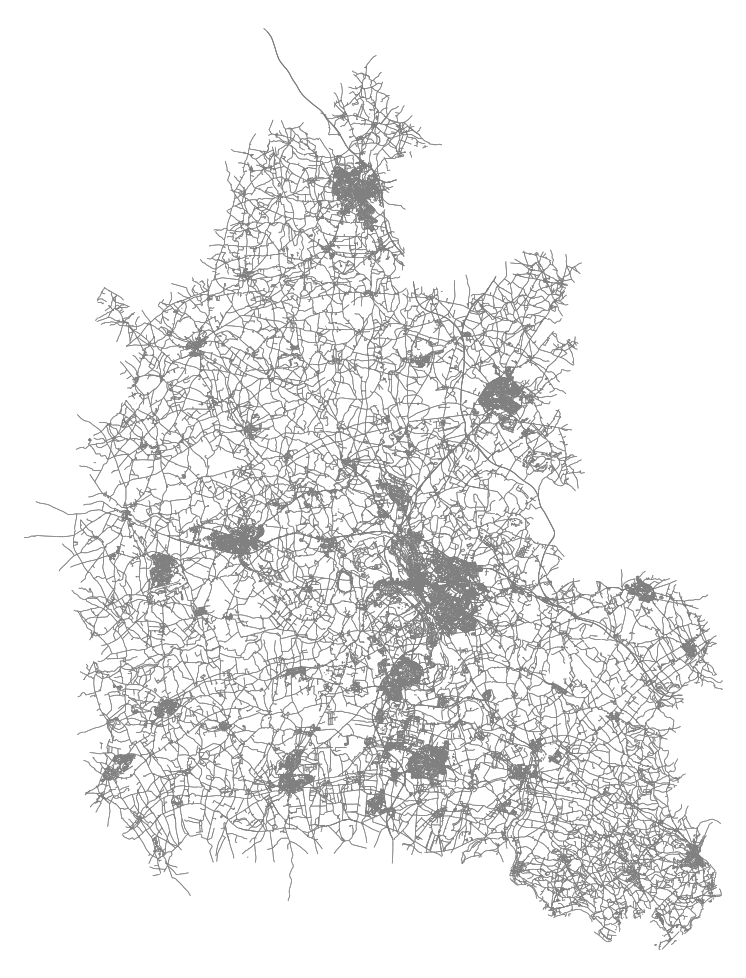

In [34]:
fig, ax = plt.subplots(figsize=(10, 10))
# hide nodes, draw edges in gray
ox.plot_graph(
    G_route,
    ax=ax,
    node_size=0,
    edge_color="gray",
    edge_linewidth=0.5,
    show=False
)
plt.tight_layout()

In [35]:
import requests


In [36]:
min_lon, min_lat, max_lon, max_lat = -1.300, 51.710, -1.200, 51.760
headers = {"User-Agent": "rizwaan3@gmail.com"}  # OSM asks for a descriptive UA


In [37]:
page = 1
while True:
    url = (
        "https://api.openstreetmap.org/api/0.6/trackpoints"
        f"?bbox={min_lon},{min_lat},{max_lon},{max_lat}&page={page}"
    )
    resp = requests.get(url, headers=headers)
    content = resp.content

    # stop if no <trkpt> in the response
    if b"<trkpt" not in content:
        print(f"No more data at page {page}. Stopping.")
        break

    filename = f"oxford-traces-page{page}.gpx"
    with open(filename, "wb") as f:
        f.write(content)
    print(f"Saved {filename} ({len(content)} bytes)")

    page += 1

Saved oxford-traces-page1.gpx (526504 bytes)
Saved oxford-traces-page2.gpx (528556 bytes)
Saved oxford-traces-page3.gpx (527188 bytes)
Saved oxford-traces-page4.gpx (526732 bytes)
Saved oxford-traces-page5.gpx (526732 bytes)
Saved oxford-traces-page6.gpx (526960 bytes)
Saved oxford-traces-page7.gpx (527872 bytes)
Saved oxford-traces-page8.gpx (526732 bytes)
Saved oxford-traces-page9.gpx (527188 bytes)
Saved oxford-traces-page10.gpx (527188 bytes)
Saved oxford-traces-page11.gpx (527416 bytes)
Saved oxford-traces-page12.gpx (526960 bytes)
Saved oxford-traces-page13.gpx (526276 bytes)
Saved oxford-traces-page14.gpx (527872 bytes)
Saved oxford-traces-page15.gpx (526960 bytes)
Saved oxford-traces-page16.gpx (526732 bytes)
Saved oxford-traces-page17.gpx (526960 bytes)
Saved oxford-traces-page18.gpx (527188 bytes)
Saved oxford-traces-page19.gpx (528556 bytes)
Saved oxford-traces-page20.gpx (526048 bytes)
Saved oxford-traces-page21.gpx (526265 bytes)
Saved oxford-traces-page22.gpx (526243 byte

In [40]:
def load_gpx_dir(gpx_folder):
    records = []
    for fp in glob.glob(f"{gpx_folder}/*.gpx"):
        with open(fp, "r") as f:
            gpx = gpxpy.parse(f)
        # flatten all tracks & segments into one linestring per file
        for ti, track in enumerate(gpx.tracks):
            for si, seg in enumerate(track.segments):
                pts = [(pt.longitude, pt.latitude) for pt in seg.points]
                if len(pts) >= 2:
                    records.append({
                        "geometry": LineString(pts),
                        "source": fp,
                        "track_idx": ti,
                        "seg_idx": si
                    })
    return gpd.GeoDataFrame(records, crs="EPSG:4326")


In [41]:
gdf_routes = load_gpx_dir("gpx_traces")
print(f"Loaded {len(gdf_routes)} route‑segments")

Loaded 1750 route‑segments


In [47]:
sample_routes = gdf_routes.sample(n=20)

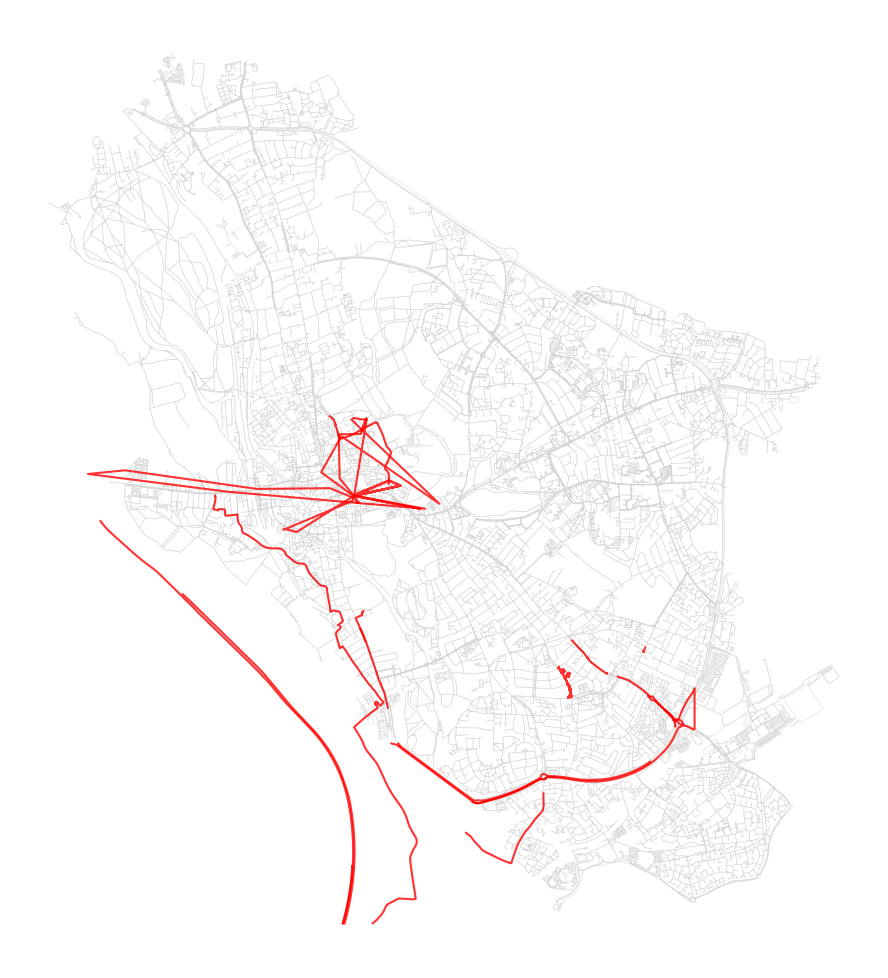

In [48]:
fig, ax = plt.subplots(figsize=(10, 10))
# plot the base map (your OSMnx edges) if you have it as `gdf_edges`:
gdf_edges.plot(ax=ax, linewidth=0.5, edgecolor="lightgray", alpha=0.6)

# overlay the sampled routes
sample_routes.plot(ax=ax, linewidth=1.5, color="red", alpha=0.8)

ax.set_axis_off()
plt.tight_layout()
plt.show()

In [50]:
# Haversine formula to compute distance between two points
def haversine(lon1, lat1, lon2, lat2):
    R = 6371.0  # Earth radius in kilometers
    phi1, phi2 = math.radians(lat1), math.radians(lat2)
    dphi = math.radians(lat2 - lat1)
    dlambda = math.radians(lon2 - lon1)
    a = math.sin(dphi/2)**2 + math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    return 2 * R * math.asin(math.sqrt(a))

In [56]:
gpx_folder = 'gpx_traces'

In [67]:
records = []
ns = {'gpx': 'http://www.topografix.com/GPX/1/0'}

In [68]:
for fp in glob.glob(f"{gpx_folder}/*.gpx"):
    tree = ET.parse(fp)
    root = tree.getroot()
    trkpts = root.findall('.//gpx:trkpt', ns)
    if len(trkpts) < 2:
        continue

    total_dist = 0.0  # in km
    total_time = 0.0  # in seconds

    prev_lat = float(trkpts[0].attrib['lat'])
    prev_lon = float(trkpts[0].attrib['lon'])
    time_elem = trkpts[0].find('gpx:time', ns)
    prev_time = datetime.strptime(time_elem.text, '%Y-%m-%dT%H:%M:%SZ') if time_elem is not None else None

    for pt in trkpts[1:]:
        lat = float(pt.attrib['lat'])
        lon = float(pt.attrib['lon'])
        time_elem = pt.find('gpx:time', ns)
        curr_time = datetime.strptime(time_elem.text, '%Y-%m-%dT%H:%M:%SZ') if time_elem is not None else None

        total_dist += haversine(prev_lon, prev_lat, lon, lat)
        if prev_time and curr_time:
            total_time += (curr_time - prev_time).total_seconds()

        prev_lat, prev_lon, prev_time = lat, lon, curr_time

    if total_time > 0:
        avg_speed_kmh = total_dist / (total_time / 3600)
        records.append({
            "filepath": fp,
            "distance_km": round(total_dist, 2),
            "duration_h": round(total_time / 3600, 2),
            "avg_speed_kmh": round(avg_speed_kmh, 2)
        })

In [69]:
df_speeds = pd.DataFrame(records)

In [70]:
df_speeds

,filepath,distance_km,duration_h,avg_speed_kmh
0,gpx_traces/oxford-traces-page194.gpx,0.70,0.00,178.88
1,gpx_traces/oxford-traces-page209.gpx,0.77,7.72,0.10
2,gpx_traces/oxford-traces-page221.gpx,0.34,7.86,0.04
3,gpx_traces/oxford-traces-page220.gpx,14.70,12.57,1.17
4,gpx_traces/oxford-traces-page208.gpx,0.99,8.75,0.11
5,gpx_traces/oxford-traces-page195.gpx,4.39,0.02,210.62
6,gpx_traces/oxford-traces-page237.gpx,46.98,495.22,0.09
7,gpx_traces/oxford-traces-page192.gpx,6.42,0.04,161.63
8,gpx_traces/oxford-traces-page227.gpx,20.74,4138.33,0.01
9,gpx_traces/oxford-traces-page233.gpx,89.16,9821.46,0.01


In [66]:
with open("gpx_traces/oxford-traces-page1.gpx") as f:
    for _ in range(10):
        print(f.readline().rstrip())

<?xml version="1.0" encoding="UTF-8"?>
<gpx version="1.0" creator="OpenStreetMap.org" xmlns="http://www.topografix.com/GPX/1/0">
  <trk>
    <name>2023_10_16T12_38_53.534143.gpx</name>
    <desc>Routes from dragonpilot 2023.07.05 (TOYOTA COROLLA HYBRID TSS2 2019).</desc>
    <url>/user/dragonpilot/traces/11101690</url>
    <trkseg>
      <trkpt lat="51.7255157" lon="-1.2426825">
        <time>2023-10-16T12:39:12Z</time>
      </trkpt>
